## Import Libraries and load data


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor, plot_importance
from xgboost.callback import EarlyStopping

# Paths
DATA_DIR = Path("/Users/nigelcmc/Downloads/Proprocessed_Dataset.csv")  # update this to your notebook's directory if needed
MODEL_DIR = Path("xgb_models")
MODEL_DIR.mkdir(exist_ok=True)

# Random seed
RANDOM_STATE = 42

In [21]:
import sys, xgboost
print(sys.executable)
print(xgboost.__version__)

/usr/local/bin/python3
3.0.5


In [22]:
# Load the pre-split datasets
X_train = pd.read_csv(DATA_DIR / "X_train.csv")
X_val   = pd.read_csv(DATA_DIR / "X_val.csv")
X_test  = pd.read_csv(DATA_DIR / "X_test.csv")

y_train = pd.read_csv(DATA_DIR / "y_train.csv").squeeze().astype(float)
y_val   = pd.read_csv(DATA_DIR / "y_val.csv").squeeze().astype(float)
y_test  = pd.read_csv(DATA_DIR / "y_test.csv").squeeze().astype(float)

## Encode Categorical Features


In [23]:
with open(DATA_DIR / "metadata.json", "r") as f:
    meta = json.load(f)

cat_features = meta["categorical_features"]  # 23 cat cols
num_features = meta["numerical_features"]    # 16 numeric cols
# --- 0) Drop junk/ID columns from data and from feature lists ---
ID_COLS = {"Unnamed: 0", "OPERATION_ID", "PATIENT_CODE"}  # index + identifiers
for df in (X_train, X_val, X_test):
    to_drop = [c for c in ID_COLS if c in df.columns]
    if to_drop:
        df.drop(columns=to_drop, inplace=True)

# also remove from metadata lists if present
cat_features = [c for c in cat_features if c not in ID_COLS]
num_features = [c for c in num_features if c not in ID_COLS]

# --- 1) Reclassify any "numerical" feature that is actually object-typed ---
# Find object-typed columns across train (do val/test similarly if you prefer)
obj_in_train = [c for c in X_train.columns if X_train[c].dtype == 'object']

# If any of those are listed as numerical, move them to categoricals.
# (Typical cases: ADMISSION_BED is an alphanumeric code; treat as categorical.)
misclassified = [c for c in obj_in_train if c in num_features]
if misclassified:
    print("[Info] Moving misclassified numericals to categorical:", misclassified)
    # update lists
    num_features = [c for c in num_features if c not in misclassified]
    cat_features = sorted(set(cat_features + misclassified))

# --- 2) Align columns across splits (safety) ---
common_cols = sorted(set(X_train.columns) & set(X_val.columns) & set(X_test.columns))
X_train, X_val, X_test = X_train[common_cols], X_val[common_cols], X_test[common_cols]

# --- 3) Rebuild expected_cols and proceed ---
expected_cols = cat_features + num_features
missing_in_train = [c for c in expected_cols if c not in X_train.columns]
if missing_in_train:
    print("[Info] Skipping features absent from X_train:", missing_in_train)
    cat_features = [c for c in cat_features if c in X_train.columns]
    num_features = [c for c in num_features if c in X_train.columns]
    expected_cols = cat_features + num_features

expected_cols = cat_features + num_features
missing_in_train = [c for c in expected_cols if c not in X_train.columns]
if missing_in_train:
    raise ValueError(f"Missing columns in X_train: {missing_in_train}")

def label_encode_splits(X_tr, X_va, X_te, cat_cols):
    X_tr_e, X_va_e, X_te_e = X_tr.copy(), X_va.copy(), X_te.copy()
    encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        # Fit on union of all splits to avoid unseen-label errors later
        universe = pd.concat([X_tr_e[col], X_va_e[col], X_te_e[col]], axis=0).astype(str).fillna("Unknown")
        le.fit(universe)
        encoders[col] = le
        for X_ in (X_tr_e, X_va_e, X_te_e):
            X_[col] = le.transform(X_[col].astype(str).fillna("Unknown"))
    return X_tr_e, X_va_e, X_te_e, encoders

X_train_enc, X_val_enc, X_test_enc, label_encoders = label_encode_splits(
    X_train, X_val, X_test, cat_features
)

# Safety checks
for name, X_ in [("train", X_train_enc), ("val", X_val_enc), ("test", X_test_enc)]:
    assert X_.isnull().sum().sum() == 0, f"NaNs remain in {name}"
print("Encoded shapes:", X_train_enc.shape, X_val_enc.shape, X_test_enc.shape)

[Info] Moving misclassified numericals to categorical: ['ADMISSION_BED']
Encoded shapes: (174148, 36) (24879, 36) (49757, 36)


## Model Set Up

In [24]:
xgb = XGBRegressor(
    n_estimators=3000,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=2,
    reg_lambda=1.0,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    # 3.x: put these in the constructor
    eval_metric=["mae", "rmse"],
    early_stopping_rounds=200,
)

xgb.fit(
    X_train_enc, y_train,
    eval_set=[(X_val_enc, y_val)],
    verbose=200
)

[0]	validation_0-mae:41.45723	validation_0-rmse:56.13022
[200]	validation_0-mae:17.76430	validation_0-rmse:27.55649
[400]	validation_0-mae:17.42609	validation_0-rmse:27.10768
[600]	validation_0-mae:17.27227	validation_0-rmse:26.92125
[800]	validation_0-mae:17.18226	validation_0-rmse:26.82374
[1000]	validation_0-mae:17.13261	validation_0-rmse:26.77665
[1200]	validation_0-mae:17.10094	validation_0-rmse:26.74890
[1400]	validation_0-mae:17.07776	validation_0-rmse:26.73626
[1558]	validation_0-mae:17.07412	validation_0-rmse:26.74441


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=200,
             enable_categorical=False, eval_metric=['mae', 'rmse'],
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=-1,
             num_parallel_tree=None, ...)

<Figure size 900x1000 with 0 Axes>

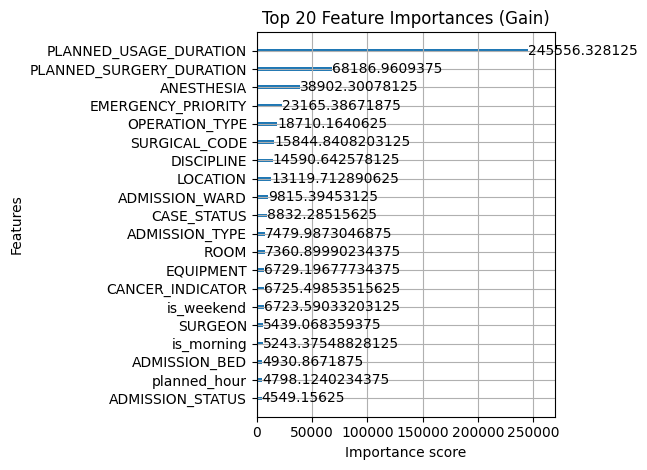

In [25]:
plt.figure(figsize=(9, 10))
plot_importance(xgb, importance_type="gain", max_num_features=20)
plt.title("Top 20 Feature Importances (Gain)")
plt.tight_layout()
plt.show()

## Model Evaluation

In [26]:
def evaluate(name, model, X, y):
    pred = model.predict(X)
    rmse = mean_squared_error(y, pred, squared=False)
    mae  = mean_absolute_error(y, pred)
    r2   = r2_score(y, pred)
    print(f"[{name}] RMSE={rmse:.3f}  MAE={mae:.3f}  R²={r2:.3f}")
    return rmse, mae, r2

evaluate("VAL ", xgb, X_val_enc,  y_val)
evaluate("TEST", xgb, X_test_enc, y_test)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[VAL ] RMSE=26.734  MAE=17.080  R²=0.783
[TEST] RMSE=26.672  MAE=17.112  R²=0.780


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(26.671718494011287, 17.111804352831523, 0.7799768234627156)